<a href="https://colab.research.google.com/github/AjeetSingh02/Notebooks/blob/master/pytorchToKerasUsingOnnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Case: Handwritten Digits Classification

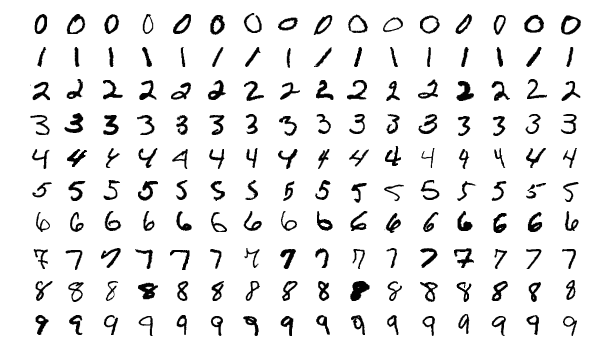

**Use case brief**: We want to create a ML model which can take a image as input and successfully classify it as a digit between 0 and 9.

we will create a Multi-Layered Perceptron (MLP) network for building a handwritten digit classifier. We will make use of the MNIST dataset included in the torchvision package.

 we will use different utility packages provided within PyTorch (nn, autograd, optim, torchvision, torchtext, etc.) to build and train neural networks.

# Installation

Install the necessary packages which doesnt come with Collab by default. If you are running outside Google Colab then you need to install all the packages mentioned in the last cell/part of this notebook.

In [ ]:
! pip install onnx

In [ ]:
! pip install onnx2keras

In [ ]:
! pip install onnxruntime

# Data loading and processing

The first step, as with any project you’ll work on, is data preprocessing. We need to transform the raw dataset into tensors and normalize them in a fixed range. The torchvision package provides a utility called transforms which can be used to combine different transformations together.

In [ ]:
from torchvision import transforms

_tasks = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

The first transformation converts the raw data into tensor variables and the second transformation performs normalization using the below operation:

x_normalized = x-mean / std

In [ ]:
from torchvision.datasets import MNIST

In [ ]:
## Load MNIST Dataset and apply transformations
mnist = MNIST("data", download=True, train=True, transform=_tasks)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Data Visualization

Lets now take a look at the dataset

In [ ]:
from torch.utils.data import DataLoader

rawData = DataLoader(mnist, batch_size=10)

dataiter = iter(rawData)
data, labels = dataiter.next()
data = data.view(data.shape[0], -1)

print(f"shape", data.shape)

shape torch.Size([10, 784])


This dataset contains images of handwritten numbers. Each image (originally a matrix of shape 28×28) is squeezed in a vector of shape 1×784.

Every example in the dataset will be a vector of shape 1×784. We can get the original image by reshaping the example into a 28×28 matrix.

This is how starting 200 values of 1st vector (image) looks like:

In [ ]:
data[0][:200]

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

Since numbers like above are not very intuitive, Lets try to visualize the images. Note the in the code we have reshaped the vector into 28×28 matrix for plotting.

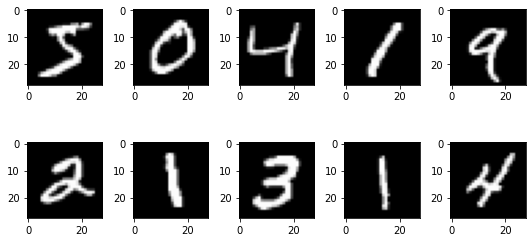

In [ ]:
import matplotlib.pyplot as plt

num=10
num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    pixels = data[i].numpy()
    pixels = pixels.reshape((28,28))
    ax.imshow(pixels, cmap='gray')
plt.tight_layout()
plt.show()

So this is how our images will look like when plotted. Lets move ahead towards the other parts.

# Pytorch Model Training and Predictions

Another excellent utility of PyTorch is DataLoader iterators which provide the ability to batch, shuffle and load the data in parallel using multiprocessing workers. For the purpose of evaluating our model, we will partition our data into training and validation sets.

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
## create training and validation split 
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [ ]:
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
## create iterator objects for train and valid datasets
trainloader = DataLoader(mnist, batch_size=256, sampler=tr_sampler)
validloader = DataLoader(mnist, batch_size=256, sampler=val_sampler)

The neural network architectures in PyTorch can be defined in a class which inherits the properties from the base class from nn package called Module. This inheritance from the nn.Module class allows us to implement, access, and call a number of methods easily. We can define all the layers inside the constructor of the class, and the forward propagation steps inside the forward function.

We will define a network with the following layer configurations: [784, 128,10]. This configuration represents the 784 nodes (28*28 pixels) in the input layer, 128 in the hidden layer, and 10 in the output layer. Inside the forward function, we will use the sigmoid activation function in the hidden layer (which can be accessed from the nn module).

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(784, 128)
        self.output = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.hidden(x)
        x = F.sigmoid(x)
        x = self.output(x)
        return x

In [ ]:
model = Model()

Define the loss function and the optimizer using the nn and optim package:

In [ ]:
from torch import optim
import numpy as np
import torch

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-6, momentum = 0.9, nesterov = True)

We are now ready to train the model. The core steps will be: Forward Propagation, Loss Computation, Backpropagation, and updating the parameters.

In [ ]:
for epoch in range(1, 11): ## run the model for 10 epochs
    train_loss, valid_loss = [], []
    ## training part 
    model.train()
    for data, target in trainloader:
        optimizer.zero_grad()
        ## 1. forward propagation
        data = data.view(data.shape[0], -1)
        output = model(data)
        
        ## 2. loss calculation
        loss = loss_function(output, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        train_loss.append(loss.item())
        
    ## evaluation part 
    model.eval()
    for data, target in validloader:
        data = data.view(data.shape[0], -1)
        output = model(data)
        loss = loss_function(output, target)
        valid_loss.append(loss.item())
    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss))

Once the model is trained, make the predictions on the validation data. We will use the predicted values to see if our pytorch model and converted Keras model output same values or not.

In [ ]:
## dataloader for validation dataset 
dataiter = iter(validloader)
data, labels = dataiter.next()
data = data.view(data.shape[0], -1)
output = model(data)

In [ ]:
_, preds_tensor = torch.max(output, 1)
pytorchPredictions = np.squeeze(preds_tensor.numpy())

Now that we have our trained Pytorch model and we have saved the predictions, we will convert the pytorch model into ONNX format and then inturn convert that into Keras model. 

# Export to ONNX and Inference using ONNX runtime

What is ONNX ?

ONNX stands for Open Neural Network Exchange

ONNX is an open-source artificial intelligence ecosystem.
It is a new standard for exchanging deep learning models. It promises to make deep learning models portable thus preventing vendor lock in.

ONNX is developed and supported by a community of partners such as Microsoft, Facebook and AWS.

For more information on ONNX refer this [link](https://github.com/onnx/onnx).

In [ ]:
# ONNX is natively supported by Pytorch so we just need 
# these 2 lines to export Pytorch model to ONNX.

# while running inferences you will have to pass data of this shape only
x = torch.randn(1, 1, 256, 784, requires_grad=True)
torch.onnx.export(model, x, "torchToOnnx.onnx", verbose=True, input_names = ['input'], output_names = ['output'])

The ONNX model is saved with "torchToOnnx.onnx" name in current file system.

 If our aim is to just run inference then we can run inferences directly using ONNX object only. For that we will need to take help of ONNX runtime. Here is how you can do that:

**Inferences using ONNX:**

In [ ]:
import onnxruntime as rt
import numpy

sess = rt.InferenceSession("/content/torchToOnnx.onnx")
input_name = sess.get_inputs()[0].name

# Note: The input must be of the same shape as the shape of x during the 
# model export part. i.e. second argument in this function call: torch.onnx.export()
onnxPredictions = sess.run(None, {input_name: data.numpy().reshape(1,1,256,784)})[0]

We will look at the predicted values at the end. For now lets move forward and convert the model to Keras.

# ONNX to Keras conversion and prediction on keras model

ONNX to Keras is not natively supported but thanks to generous Python community we have [onnx2keras](https://pypi.org/project/onnx2keras/) which does that for us.

In [ ]:
import onnx
from onnx2keras import onnx_to_keras

In [ ]:
# Load ONNX model
onnx_model = onnx.load('/content/torchToOnnx.onnx')

In [ ]:
# Call the converter (input will be equal to the input_names parameter that you defined during exporting)
k_model = onnx_to_keras(onnx_model, ['input'])

Let us see the summary of Keras model to see if its imported properly

In [ ]:
k_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1, 256, 784) 0                                            
__________________________________________________________________________________________________
6 (Dense)                       (None, 1, 256, 128)  100352      input[0][0]                      
__________________________________________________________________________________________________
7_const2 (Lambda)               (128,)               0           input[0][0]                      
__________________________________________________________________________________________________
7 (Lambda)                      (None, 1, 256, 128)  0           6[0][0]                          
                                                                 7_const2[0][0]        

Now that we have Keras model we can generate predictions on the same dataset and compare with the outputs of the Pytorch model to validate the conversion.

In [ ]:
KerasPredictions = []
for i in range(10):
    inp = data[i].numpy()
    out = k_model.predict(inp.reshape(1, 784))
    KerasPredictions.append(np.argmax(out))

# Predictions comparision

Lets first see the original images

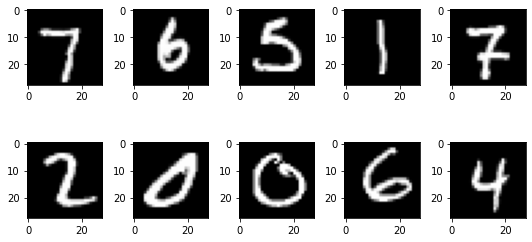

In [ ]:
num=10
num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    pixels = data[i].numpy()
    pixels = pixels.reshape((28,28))
    ax.imshow(pixels, cmap='gray')
plt.tight_layout()
plt.show()

**Actual Labels for the images**

In [ ]:
labels[:10]

tensor([7, 6, 5, 1, 7, 2, 0, 0, 6, 4])

**Predictions using original Pytorch model**

In [ ]:
pytorchPredictions[:10]

array([7, 6, 5, 1, 7, 2, 0, 0, 6, 4])

**Predictions using ONNX runtime**

In [ ]:
np.argmax(onnxPredictions[0][0][:10], axis=1)

array([7, 6, 5, 1, 7, 2, 0, 0, 6, 4])

**Predictions using converted Keras model**

In [ ]:
KerasPredictions

[7, 6, 5, 1, 7, 2, 0, 0, 6, 4]

As we can see in the last three cells the outputs are same for Pytorch, Keras and onnx models and thus our conversion worked.

# Packages versions and References

Following are the versions of the packages used in the notebook

1. torch: 1.6.0+cu101
2. onnx: 1.7.0
3. numpy: 1.18.5
4. onnx2keras: 0.0.23
5. torchvision: 0.7.0+cu101
6. matplotlib: 3.2.2
7. onnxruntime: 1.5.2

References:
1. https://www.analyticsvidhya.com/blog/2019/01/guide-pytorch-neural-networks-case-studies/
2. https://medium.com/@mrdatascience/how-to-plot-mnist-digits-using-matplotlib-65a2e0cc068
3. https://blog.paperspace.com/what-every-ml-ai-developer-should-know-about-onnx/
4. https://microsoft.github.io/ai-at-edge/docs/onnx/ 	
5. https://medium.com/analytics-vidhya/how-to-convert-your-keras-model-to-onnx-8d8b092c4e4f